In [146]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np

sys.path.append(os.path.abspath('../../Cochlear_Implant_Hackathon/'))

from software.models.single_vect_model import FitnessWrapper,VectorClass
from software.fitness_functions.delta_wav import compute_wavfile_delta
# Import the rest of the GpyT subpackage functions for the demo here

from software.AB_imports.Demo.proceduralDemo import demo4_procedural
from scipy.fftpack import fft,rfft,irfft,ifft
from sklearn.preprocessing import StandardScaler
import pyaudio as pa
from scipy.signal import resample
from scipy.io.wavfile import read as wavread
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    plt.style.use('rossidata')
except:
    pass
from scipy.signal import convolve,hilbert,lfilter,medfilt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
# gp packages
import random
from deap import algorithms, base, creator, tools, gp
import operator
import math

# Building Genetic Programming
# part 1: declaring primatives


In [130]:
!ls ../sample_data/sentence1_55_clean.wav

sentence1_55_clean.wav sentence2_55_clean.wav sentence3_55_clean.wav


In [223]:
fw = FitnessWrapper(os.path.abspath('../sample_data/sentence1_55_clean.wav'))

### Primitive Functions


def vector_multiply(vc,x):
    if x is not None:
        vc.data=np.multiply(vc.data,x)
        return vc
    else:
        return vc

def vector_convolve(vc1,vc2):
    vc1.data=convolve(vc1.data, vc2.data, mode='same')
    return vc1

def vector_medfilter(vc,x_int):
    if x_int is not None:
        vc.data=medfilt(vc.data,x_int)
        return vc
    else:
        return vc
    
def float_to_int(x):

    return int(3)

    
pset = gp.PrimitiveSetTyped("MAIN", [VectorClass],VectorClass)

pset.addPrimitive(vector_multiply, [VectorClass,float], VectorClass)
pset.addPrimitive(vector_convolve,[VectorClass,VectorClass],VectorClass)
#pset.addPrimitive(vector_medfilter,[VectorClass,int],VectorClass)

pset.addPrimitive(operator.neg, [float],float)
# pset.addPrimitive(float_to_int, [float],int)

#pset.addEphemeralConstant("odd_int8888", lambda: random.randrange(1, 101+1, 20), int)


pset.addEphemeralConstant("new_uniform88888", lambda: random.uniform(0, 2), float)


# part 2 : defining functions

In [224]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

/Users/nicholas.rossi/Library/Python/3.7/lib/python/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/nicholas.rossi/Library/Python/3.7/lib/python/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [225]:
toolbox = base.Toolbox()
toolbox.register("expr_init", gp.genFull, pset=pset, min_=1, max_=2)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


part 3 : define dataclass

In [226]:
def evalSymbTransform(individual, fw):
    transform = toolbox.compile(expr=individual)
    score = fw.score_new_transform(transform)
    return score,

part 4: define toolbox

In [227]:
toolbox.register("evaluate", evalSymbTransform, fw=fw)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [228]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [229]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                               halloffame=hof, verbose=True)

/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:270: RuntimeWarning: invalid value encountered in true_divide
  audioOut = audioOut/np.sqrt(np.mean(np.square(audioOut)))*10**(-25/20)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:270: RuntimeWarning: invalid value encountered in true_divide
  audioOut = audioOut/np.sqrt(np.mean(np.square(audioOut)))*10**(-25/20)


   	      	                  fitness                  	                      size                     
   	      	-------------------------------------------	-----------------------------------------------
gen	nevals	avg	gen	max	min	nevals	std	avg    	gen	max	min	nevals	std    
0  	300   	nan	0  	nan	nan	300   	nan	4.65667	0  	7  	3  	300   	1.75844


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

1  	154   	nan	1  	nan	nan	154   	nan	5.41   	1  	13 	1  	154   	2.07892


/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:270: RuntimeWarning: invalid value encountered in true_divide
  audioOut = audioOut/np.sqrt(np.mean(np.square(audioOut)))*10**(-25/20)


2  	167   	nan	2  	nan	nan	167   	nan	6.2    	2  	14 	1  	167   	2.22261


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0


3  	160   	nan	3  	nan	nan	160   	nan	6.45   	3  	15 	1  	160   	2.12623


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Pyt

4  	152   	nan	4  	nan	nan	152   	nan	6.56   	4  	13 	1  	152   	2.10073


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

5  	165   	nan	5  	nan	nan	165   	nan	6.49   	5  	15 	1  	165   	2.27667


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axe

6  	169   	nan	6  	nan	nan	169   	nan	6.42667	6  	18 	1  	169   	2.4667 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axe

7  	154   	nan	7  	nan	nan	154   	nan	6.57   	7  	16 	1  	154   	2.36187


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:270: RuntimeWarning: invalid value encountered in true_divide
  audioOut = audioOut/np.sqrt(np.mean(np

8  	175   	nan	8  	nan	nan	175   	nan	6.48667	8  	16 	1  	175   	2.3671 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Pyt

9  	149   	nan	9  	nan	nan	149   	nan	6.42333	9  	16 	3  	149   	2.28855


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Pyt

10 	173   	nan	10 	nan	nan	173   	nan	6.37333	10 	18 	1  	173   	2.29215


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

11 	174   	nan	11 	nan	nan	174   	nan	6.54   	11 	18 	3  	174   	2.53937


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Pyt

12 	162   	nan	12 	nan	nan	162   	nan	6.68667	12 	18 	3  	162   	2.49703


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Pyt

13 	174   	nan	13 	nan	nan	174   	nan	6.55   	13 	17 	1  	174   	2.36942


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

14 	168   	nan	14 	nan	nan	168   	nan	6.32   	14 	19 	1  	168   	2.1949 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Pyt

15 	148   	nan	15 	nan	nan	148   	nan	6.47667	15 	21 	1  	148   	2.49989


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

16 	161   	nan	16 	nan	nan	161   	nan	6.18   	16 	17 	1  	161   	2.44287


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

17 	156   	nan	17 	nan	nan	156   	nan	6.26667	17 	17 	1  	156   	2.54471


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axe

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Pyt

18 	165   	nan	18 	nan	nan	165   	nan	6.24667	18 	17 	1  	165   	2.73115


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0


19 	174   	nan	19 	nan	nan	174   	nan	6.33667	19 	19 	1  	174   	2.73678


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

20 	158   	nan	20 	nan	nan	158   	nan	6.61   	20 	22 	1  	158   	3.24107


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

21 	158   	nan	21 	nan	nan	158   	nan	6.54333	21 	22 	1  	158   	3.27436


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axe

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

22 	172   	nan	22 	nan	nan	172   	nan	6.76667	22 	23 	3  	172   	3.40865


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axe

23 	170   	nan	23 	nan	nan	170   	nan	6.53   	23 	21 	1  	170   	3.04233


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/models/single_vect_model.py:57: RuntimeWarning: invalid value encountered in multiply
  normalized = scaler.transform(values) * original_std
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWarning: invalid value encountered in less
  elData [elData < 0 ] = 0
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axe

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

24 	162   	nan	24 	nan	nan	162   	nan	6.77667	24 	23 	1  	162   	3.26805


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: overflow encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/signaltools.py:415: RuntimeWarning: invalid value encountered in multiply
  ret = np.fft.irfftn(sp1 * sp2, fshape, axes=axes)[fslice].copy()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Vocoder/vocoder.py:222: RuntimeWar

KeyboardInterrupt: 

In [ ]:
# Visualization and Plotting

In [23]:
np.multiply(np.arange(1),4)

array([0])

In [26]:
np.subtract(np.arange(10),4)

array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5])

In [51]:
arr = np.array([0.5, 1.0, 1.5])

print(arr.dtype)

float64


In [54]:
np.multiply(arr,4)

array([2., 4., 6.])

In [81]:
model_struct.prepped_data.shape


(288891,)

In [84]:
convolve(model_struct.prepped_data,model_struct.prepped_data,mode='same').shape

(288891,)

In [256]:
sin_wav=np.sin(np.linspace(0,2*np.pi,100))
rand_wav=np.random.random(100)
sin_rand_wav=sin_wav+rand_wav
hilb_sin=np.abs((hilbert(sin_wav)))
hilb_rand=np.abs((hilbert(rand_wav)))
hilb_sin_rand=np.abs((hilbert(sin_rand_wav)))

cos_wav=np.cos(np.linspace(0,2*np.pi,100))

covolved=convolve(sin_wav,sin_wav,mode='same')

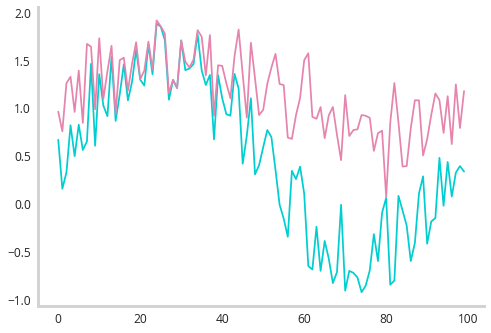

In [257]:
fig,ax=plt.subplots()
ax.plot(sin_rand_wav)
ax.plot(hilb_sin_rand)

In [245]:
np.abs((hilbert(covolved)))

array([30.54037628, 31.56455826, 31.65166717, 32.10892132, 32.26042766,
       32.62710067, 32.81364396, 33.14650127, 33.35456113, 33.66911171,
       33.89116301, 34.19319536, 34.42459904, 34.71673282, 34.95442254,
       35.23804298, 35.47987593, 35.75582825, 36.00023025, 36.26910102,
       36.51485813, 36.77709751, 37.02322645, 37.27920187, 37.52486496,
       37.77488196, 38.01932786, 38.26363288, 38.50615145, 38.74492255,
       38.98480593, 39.21813257, 39.45463555, 39.68248557, 39.91477772,
       40.13694552, 40.36404421, 40.58006873, 40.80073474, 41.00976359,
       41.222324  , 41.42287506, 41.62489742, 41.81440565, 42.00203712,
       42.17589341, 42.34231678, 42.49146143, 42.62227013, 42.72506911,
       42.77068693, 42.7260635 , 42.62227013, 42.4943898 , 42.34231678,
       42.18059814, 42.00203712, 41.82063532, 41.62489742, 41.43029183,
       41.222324  , 41.01794981, 40.80073474, 40.588533  , 40.36404421,
       40.14512802, 39.91477772, 39.68976231, 39.45463555, 39.22

In [215]:
random.randrange(1, 101+1, 4)

73

In [230]:
transform

[autoreload of software.models.single_vect_model failed: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/nicholas.rossi/Documents/Personal/

NameError: name 'transform' is not defined